### 1. ****Import Libraries****

In [5]:
# Numerical operations
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("All libraries imported successfully!")


All libraries imported successfully!


### 2. ****Load Trained Model****

In [6]:
# Load the trained MobileNet model
# (You can change this to cnn_model.h5 if required)

model = load_model("../models/mobilenet_model.h5")

print("Model loaded successfully!")


Model loaded successfully!


### 3. ****Data Generator (test)****

In [7]:
# Path to processed dataset
DATA_DIR = "../data/processed"

# Only rescaling for test data (no augmentation)
datagen = ImageDataGenerator(rescale=1./255)

# Load images from directory
test_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False   # Important to keep order same
)

print("Test generator ready!")


Found 3076 images belonging to 7 classes.
Test generator ready!


### 4. ****Make Predictions****

In [8]:
# Predict probabilities for each class
preds = model.predict(test_gen)

# Convert probabilities to class labels
y_pred = np.argmax(preds, axis=1)

# True labels
y_true = test_gen.classes

print("Predictions completed!")


c:\Users\Damod\anaconda3\envs\crop_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 90s 886ms/step
Predictions completed!


### 5. ****Confusion Matrix****

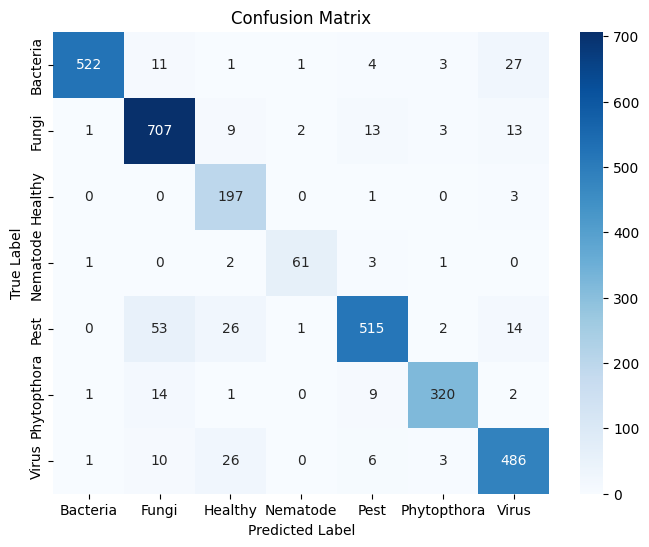

In [14]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_gen.class_indices.keys(),
    yticklabels=test_gen.class_indices.keys()
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("../results/confusion_matrix.png")
plt.show()



### 6. ****Classification Report****

In [10]:
# Detailed performance metrics
# Precision, Recall, F1-score for each class

report = classification_report(
    y_true,
    y_pred,
    target_names=test_gen.class_indices.keys()
)

print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

    Bacteria       0.99      0.92      0.95       569
       Fungi       0.89      0.95      0.92       748
     Healthy       0.75      0.98      0.85       201
    Nematode       0.94      0.90      0.92        68
        Pest       0.93      0.84      0.89       611
 Phytopthora       0.96      0.92      0.94       347
       Virus       0.89      0.91      0.90       532

    accuracy                           0.91      3076
   macro avg       0.91      0.92      0.91      3076
weighted avg       0.92      0.91      0.91      3076



### 7. ****GradCAM Function****

In [11]:
# This function creates a heatmap
# showing which part of image model focused on

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    
    # Create a model that maps input image
    # to last convolution layer output + predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient of predicted class
    grads = tape.gradient(class_channel, conv_outputs)

    # Average gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    # Multiply filters with gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap.numpy()


### 8. ****Apply GradCAM On Sample Image****

c:\Users\Damod\anaconda3\envs\crop_env\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


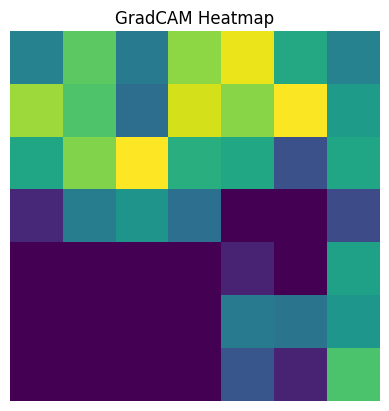

In [12]:
import cv2
import os

# Select one random image
sample_class = list(test_gen.class_indices.keys())[0]

img_name = os.listdir("../data/processed/" + sample_class)[0]
img_path = "../data/processed/" + sample_class + "/" + img_name

# Read and preprocess image
img = cv2.imread(img_path)
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_array = np.expand_dims(img/255.0, axis=0)

# Generate heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="Conv_1"  # MobileNet last conv layer
)

# Show heatmap
plt.imshow(heatmap)
plt.title("GradCAM Heatmap")
plt.axis("off")
plt.show()


### 9. ****Overlay Heatmap On Original Image****

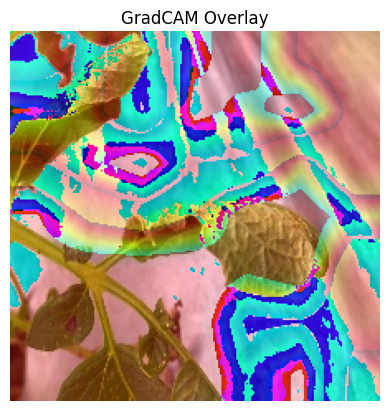

In [15]:
# Resize heatmap to image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert to color map
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on original image
superimposed_img = heatmap * 0.4 + img

plt.imshow(superimposed_img.astype("uint8"))
plt.title("GradCAM Overlay")
plt.axis("off")
plt.savefig("../results/gradcam.png")
plt.show()

